# ForceSMIP: Signal-to-Noise Maximizing Pattern Optimal Fingerprinting (SNMP-OF)

#### By Robb Jnglin Wills and Maren Höver

This notebook combines signal-to-noise maximizing pattern (SNMP) analysis - see Wills et al. (2020, https://doi.org/10.1175/JCLI-D-19-0855.1) are references therein - with optimal fingerprinting. The basic idea is that fingerprints of climate change that have high signal-to-noise ratios are identified in climate models with SNMP analysis and then the time evolution of those patterns are found in observations (or individual members of large ensembles for training and evaluation). In a final step, the patterns are recomputed from the observations/individual members through a regression of the data matrix on the time series.

#### Outline:

* Basics on data structure, training and evalution data (modified from LFCA notebook)
* Notes on setup with conda
* Import of key packages
* User-specified options
* Loading in the ForceSMIP data
    * Defining a function to read in data
    * Loading monthly anomaly maps for the evaluation data
    * Loading monthly anomaly maps for the training data
    * Calculating the ensemble-mean monthly anomaly maps for the training data
* Apply LFCA to the training models for various values of the hyperparameters (EOF truncation and number of low-frequency components included in the forced response)
* Evaluate the skill of LFCA for the training data
* Apply LFCA to the evaluation data for specified hyperparameters

### Data structure, training and evaluation data

SNMP analyzes a data matrix with a size of the number of samples (n<sub>t</sub> x n<sub>e</sub>) by the number of spatial points (n<sub>lat</sub> x n<sub>lon</sub>). The number of samples is equal to the number of ensemble members n<sub>e</sub> times the number of timesteps n<sub>t</sub>. The notebook is set up to use monthly surface air temperature values, though you can change the variable used or try modifying it to use annual means. 

<p align="center">
  <img width=800 src="figs/anomaly_maps.png" />
</p>

This data matrix will be created for the **training data** and the **evaluation data**. For the training data, we have many ensemble members, and we can compute the forced response as the ensemble average. For the evaluation data, we only have one realization from each model, just as we only have one realization of the real world. The challenge of ForceSMIP is to come up with methods that can approximate the forced response from these single realizations, removing internal variability as we would if we were able to take an ensemble mean.

### Utilizing the training data

The training data is used both to compute the SNMPs and to choose the hyperparamters `trucation` and `N_SNMPs`. In the training step, the SNMPs are computed from 4 of the 5 training models and applied to members of the 5th training model, with each training model left out in turn. The notebook tries a few different values of `trucation` and `N_SNMPs`, then compares the forced reponse estimate to the "right answer", which for the case of the training data is the ensemble mean of the corresponding model. This notebook shows a few different possible skill estimates, and the user is free to choose which values work best for their needs depending on what they want to optimize, i.e., anomaly correlation coefficient (ACC) vs. root-mean square error (RMSE), spatial pattern of trends vs. spatiotemporal variance at monthly timescales. Once these parameters are chosen, all 5 training models are used to compute the SNMPs that are applied to estimate the forced response in the evaluation data. 

## Some setup notes

If you are using Jupyter (or Python with conda environments), there may be a `forcesmip` kernel/environment pre-installed for you to use. You can also check by clicking `Kernel` > `Change Kernel...` (and then look for a `forcesmip` kernel). You can determine if a conda environment exists by looking for it with `conda info --envs` in a terminal. If you use a pre-installed kernel, you can simply use the pre-installed `forcesmip` kernel and you do not need to continue with this setup.

This setup assumes that you have anaconda installed. If you do not, you can install miniconda (from [here](https://docs.conda.io/en/main/miniconda.html)). On some systems you may need to load or activate conda (e.g., via `module load conda` on NCAR systems). Once conda is installed and active, you can create a forcesmip environment with (the `-y` flag create the environment without a confirmation prompt): 

`conda create -n forcesmip -c conda-forge xcdat xesmf scikit-learn scipy eofs matplotlib cartopy nc-time-axis ipython ipykernel tensorflow python=3.9 -y`

> NOTE: This may take a long time (i.e., hours!). If you're in a rush and are not using neural networks, you can remove `tensorflow` from `conda install` and install it afterwards with `pip install tensorflow` (if desired). 

Activate your environment with: `conda activate forcesmip` or `source activate forcesmip`

If you'd like to be able to use this environment with Jupyter, you need to install it with:

`python -m ipykernel install --user --name forcesmip --display-name forcesmip`

### Import packages (code starts here)

In [1]:
# I/O / data wrangling
import os
import glob
import re
import numpy as np
import xarray as xr
import xcdat as xc

# on Krypton, limit to using 1/2 of the total cpus
import threadpoolctl
threadpoolctl.threadpool_limits(limits=os.cpu_count() // 2)

# data analysis
from eofs.standard import Eof
from scipy.signal import convolve, butter, filtfilt

# runtime metrics
import time as clocktime

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

### Define SNMP Analysis, Eigenvalue Analysis, and helper functions

Look under the hood. Here are the functions needed for SNMP analysis. 

Note that the EOF package is currently setup to use numpy (loaded in code block above). There is an option to switch it to xarray, which is more efficient, but it requires fixing a bug in the installed eofs package: https://stackoverflow.com/questions/71740621/eofs-xarray-raising-typeerror-using-a-dataarray-to-construct-a-variable-is-ambi. 

In [2]:
"""
Main SNR function
Authors: Maren Höver and Robb Jnglin Wills (ETH Zurich)
"""

def snmpa(x, ensemble_mean, truncation, weights, **kwargs):
    if x.ndim!=2:
        raise ValueError('x must have dimension 2 for LFCA')
    
    # Scale vector from weights
    scale = np.sqrt(weights/np.sum(weights))
    
    # center data
    x = x - np.mean(x,axis=0)
    xs = x * scale
    
    emean =  ensemble_mean - np.mean(ensemble_mean,axis=0)
    ensemble_mean = emean * scale
    #print("nsemble mean")
    #print( ensemble_mean)
    #print(np.shape(xs))
    #print(np.isnan(scale).any())
    #print(np.isnan(ensemble_mean).any())
    #print(np.isnan(xs).any())
    
    # Compute EOFs using eofs package
    # xarray version: eofs_xr=Eof(xs, center=False, ddof=1)
    eofs_xr=Eof(xs.values, center=False, ddof=1)

    fvar = eofs_xr.varianceFraction()
    cvar = np.cumsum(fvar)
       
    if truncation<1:
        trunc = [ n for n,i in enumerate(cvar) if i>truncation ][0]
    else:
        trunc = truncation
    print("Truncation = " + str(trunc))
       
    # Principal component time series (PC_k)
    pcs=eofs_xr.pcs(npcs=trunc, pcscaling=1)
    
    #print("pcs: " + str(np.shape(pcs))+ str(np.mean(pcs)))
    a_k = eofs_xr.eofs(neofs=trunc, eofscaling=1)  # The EOFs a_k
    # Filtering of PCs
    pcs_emean=np.zeros((trunc, np.shape(ensemble_mean)[0]))
    #print("pcs_emean")
    #print(np.shape(pcs_emean))
    
    #print("a_k: " + str(np.shape(a_k))+ str(np.mean(a_k)))
    for i in range(trunc):
        a_k_current = a_k[i,:] 
        pcs_emean[i,:]= np.matmul(ensemble_mean.values, a_k_current) # a_k or pci?
    #print(pcs_emean)
    
    #print("pcs_emean: " + str(np.shape(pcs_emean)) + str(np.mean(pcs_emean)))
    S_mn = np.cov(pcs_emean.T, rowvar=False) # This would be S_mn

    #print("S_mn: " + str(np.shape(S_mn))+ str(np.mean(S_mn)))
    s_k, e_k = np.linalg.eigh(S_mn) #  s_k, Eigenvectors e_k
    s_k_argsort = np.argsort(s_k)[::-1].copy() # Guarantee that eigenvalues are sorted in descending order
    s_k = s_k[s_k_argsort].copy()
    e_k = e_k[:,s_k_argsort].copy()
    
    #print("a_K: " + str(np.shape(a_k))+ str(a_k))
    #print("e_K: " + str(np.shape(e_k))+ str(np.mean(e_k)))
    u_k = eofs_xr.eofs(neofs=trunc, eofscaling=1).T@e_k 
    # xarray version: lfcs=xs@uvec # Low-frequency components (LFC_k)

    t_k = np.matmul(xs.values, u_k) #np.dot(xs,u_k) 
    v_k = eofs_xr.eofs(neofs=trunc, eofscaling=2).T@e_k #np.matmul(xs.T.values,t_k) #eofs_xr.eofs(neofs=truncation, eofscaling=2).T@e_k # S/NPs #  #
    sn_ratio = s_k / (1 - s_k)
    
    # Choose positive sign of LFCs/LFPs
    for j in range(v_k.shape[1]):
        if np.dot(v_k[:,j], scale.flatten())<0:
            v_k[:,j] = -v_k[:,j]
            t_k[:,j] = -t_k[:,j]
            u_k[:,j] = -u_k[:,j]
    v_k=v_k.T/scale # Re-scale LFPs (non-weighted)
    v_k = np.transpose(v_k)
    
    return t_k, v_k, u_k, sn_ratio, trunc


### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [3]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [4]:
root_dir = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/"  # path to forcesmip data (ETH)
#root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # path to forcesmip data (NCAR)

outdir = "data/"  # directory where output data should be saved

ncvar = "tas"  # CMIP variable name to be used

cutoff = 120 # months (lowpass cutoff) - you can also try varying this parameter
truncations = (0.5, 0.6, 0.7, 0.8) # different values of the EOF truncation to try
N_SNMPs = (1, 2, 3, 4)

# choose models for training
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
training_models = ["CESM2","CanESM5","MIROC-ES2L","MIROC6","MPI-ESM1-2-LR"]
#training_models = ["CESM2"]
n_members = 5  # number of members for training

# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3

# no need to modify the training or reference period for LFCA
tv_time_period = evalPeriods[eval_tier] # ("1950-01-01","2022-12-30")  # period of time to consider data for training
reference_period = tv_time_period # anomalies will be with respect to mean over entire period (convectional for LFCA)

### Define a function to read in data

We're going to loop over many models and realizations for training and evaluation data. To make this more readable and to reduce repeating code, we are going to define a function to do this operation.

In [5]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the anomalies
    relative to a user-defined reference_period. The function returns arrays
    of the dimensions (time, lat, lon), the 3D anomaly map, and the global
    mean time series. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : monthly average anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : monthly average, global mean anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # If you wanted annual averages instead, you could use the following:
    # ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # take spatial average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    # return values
    return ts_3d, ts_gm

### Read in evaluation data

We start with the evaluation data, because this data includes observations...and missing data. We will load the evaluation data and create a missing data mask, which we will apply to the training/evaluation data as well. That way the training and evaluation data will be consistent.

In [6]:
# first we search for the evaluation data
epath = "/".join([root_dir, "Evaluation-" + eval_tier, cmipTable[ncvar], ncvar])
efiles = glob.glob(epath + "/*.nc")
efiles = sorted(efiles, key=natsort)

# initialize dictionary to store data
evaluation_anomaly_maps = {}
missing_data_mask = {}
vid = cmipVar[ncvar]

# loop over evaluation files
for im, fn in enumerate(efiles):
    # get evaluation identifier
    model = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + model)
    # read in data for realization
    ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
    # store anomaly map
    evaluation_anomaly_maps[model] = ts_3d
    
    # create mask for missing data
    tmp = np.mean(ts_3d, axis=0)
    missing_data_mask[model] = np.where(np.isnan(tmp), np.nan, 1)

1 / 10: 1A
2 / 10: 1B
3 / 10: 1C
4 / 10: 1D
5 / 10: 1E
6 / 10: 1F
7 / 10: 1G
8 / 10: 1H
9 / 10: 1I
10 / 10: 1J


### Loop over training models and retrieve monthly anomaly maps

In [7]:
# initialize dictionary to store data
global_mean_timeseries = {}
anomaly_maps = {}
anomaly_maps_all = {}
anomaly_map_emean = {}
missing_data_mask_training = {}
all_members = {}
vid = cmipVar[ncvar]
# loop over models
models = training_models
for im, model in enumerate(models):
    # start timer
    stime = clocktime.time()
    # initialize nested dictionary for model data
    global_mean_timeseries[model] = {}
    anomaly_maps[model] = {}
    anomaly_maps_all[model] = {}
    anomaly_map_emean[model] = 0
    missing_data_mask_training[model] = {}
    current_data = []
    # get model files
    mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
    mfiles = glob.glob(mpath + "/*.nc")
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    all_members[model] = sorted(members, key=natsort)
    # print progress
    print(str(im + 1) + " / " + str(len(models)) + ": " + model + " (" + str(len(members)) + " members)")
    temp_data = []
    # loop over model members
    for imm, member in enumerate(all_members[model]):
        # define member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data for realization
        ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
        # store first N anomaly maps from training models
        # also store all data for the validation models
        if ((imm < n_members) & (model in training_models)):# | (model in validation_models):
            # store masked data in array
            anomaly_maps[model][member] = ts_3d
            temp_data.append(anomaly_maps[model][member])
        # ensemble mean anomaly map
        anomaly_map_emean[model] = anomaly_map_emean[model] + ts_3d/len(members)
        # save global mean time series for all model members
        global_mean_timeseries[model][member] = ts_gm
        # create mask for missing data
        tmp = np.mean(ts_3d, axis=0)
        missing_data_mask_training[model] = np.where(np.isnan(tmp), np.nan, 1)
        # update progress
        print(".", end="")
    anomaly_maps_all[model] = xr.concat(temp_data, dim="mem")
    anomaly_maps_all[model]["time"] = anomaly_maps_all[training_models[0]].time
    # print time elapse for model
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

1 / 5: CESM2 (50 members)
..................................................
Time elapsed: 90.39859676361084 seconds

2 / 5: CanESM5 (25 members)
.........................
Time elapsed: 41.53419303894043 seconds

3 / 5: MIROC-ES2L (30 members)
..............................
Time elapsed: 49.61278939247131 seconds

4 / 5: MIROC6 (50 members)
..................................................
Time elapsed: 76.11198568344116 seconds

5 / 5: MPI-ESM1-2-LR (30 members)
..............................
Time elapsed: 47.09643220901489 seconds



## SNMP analysis of training models for training (leave one model out at a time)

Now we apply SNMP analysis to the specified number of members, leaving out the specified training models one at a time. We use the different values of `truncation` that were specified. Depending how much training data you use and how many values of `truncation` you try, this could take a while.  

In [8]:
n_models = len(training_models)

# initialize dictionaries for LFCA output
tks_all = {}
snmps_all = {}
fingerprints_all = {}
snr_all = {}
truncation_all = {}
icol_ret_all = {}

# convert missing data mask from nans to zeros
mask = np.floor((np.nan_to_num(missing_data_mask_training[training_models[0]], nan=0) +
    np.nan_to_num(missing_data_mask_training[training_models[1]], nan=0) + 
    np.nan_to_num(missing_data_mask_training[training_models[2]], nan=0) +
    np.nan_to_num(missing_data_mask_training[training_models[3]], nan=0) + 
    np.nan_to_num(missing_data_mask_training[training_models[4]], nan=0))/5)

for ig, model in enumerate(training_models):
    
    # initialize nested dictionary for member data
    tks_all[model] = {}
    snmps_all[model] = {}
    fingerprints_all[model] = {}
    snr_all[model] = {}
    truncation_all[model] = {}
    icol_ret_all[model] = {}
    
    members  = global_mean_timeseries[model].keys()
    training_members = anomaly_maps[model].keys()
    print(model)
    # start timer
    stime = clocktime.time()

    # data for all models except chosen training model
    sst_anomalies = []
    sst_anomalies_emean = []
    if ig == 0:
        include = [1, 2, 3, 4]
    elif ig == 1:
        include = [0, 2, 3, 4]
    elif ig == 2:
        include = [0, 1, 3, 4]
    elif ig == 3:
        include = [0, 1, 2, 4]
    elif ig == 4:
        include = [0, 1, 2, 3]
    else:
        print('Warning: loop index out of bounds')
    for ia in include:
        temp = anomaly_maps_all[training_models[ia]]
        temp["time"] = anomaly_map_emean[training_models[0]].time
        sst_anomalies.append(temp)
        temp = anomaly_map_emean[training_models[ia]]
        temp["time"] = anomaly_map_emean[training_models[0]].time
        sst_anomalies_emean.append(temp)
    sst_anomalies = xr.concat(sst_anomalies, dim="model")
    sst_anomalies_emean = xr.concat(sst_anomalies_emean, dim="model")
    
    # dimensions of the data matrix
    nfeatures = nlat * nlon

    # extract coordinate vectors (same for all models, so could be moved out of the loop)
    k = list(anomaly_maps[model].keys())
    lon_axis = anomaly_maps[model][k[0]].lon
    lat_axis = anomaly_maps[model][k[0]].lat
    time = anomaly_maps[model][k[0]].time
    n_timesteps = len(time)

    # create cos(lat) weighting, with mask for missing data 
    y, x = np.meshgrid(lat_axis,lon_axis)
    area = np.cos(y*np.pi/180.) * np.transpose(mask)
    area_weights = np.reshape(area,(nfeatures,1),order='F')

    # combine lat & lon into a single spatial dimension
    x = sst_anomalies.stack(sample=['model','mem','time']).stack(shape=['lat','lon'])
    x_emean = sst_anomalies_emean.stack(sample=['model','time']).stack(shape=['lat','lon'])

    # these give the spatial points (columns) where there are not and are missing data, in icol_ret and icol_disc, respectively
    icol_ret = np.where(area_weights!=0)
    icol_disc = np.where(area_weights==0)
    # remove missing spatial points from x, x_emean, and area_weights
    x = x[:,icol_ret[0]]
    x_emean = x_emean[:,icol_ret[0]]
    area_weights = np.transpose(area_weights[icol_ret[0],:])

    icol_ret_all[model] = icol_ret
    # loop over the chosen EOF truncations and perform SNMP using the function defined above
    for truncation in truncations:
        tks_all[model][str(truncation)], snmps_all[model][str(truncation)], fingerprints_all[model][str(truncation)], snr_all[model][str(truncation)], truncation_all[model][str(truncation)] =  snmpa(x, x_emean, truncation, area_weights)

    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

CESM2
Truncation = 12
Truncation = 20
Truncation = 35
Truncation = 69

Time elapsed: 1815.0061838626862 seconds

CanESM5
Truncation = 13
Truncation = 21
Truncation = 36
Truncation = 70

Time elapsed: 1051.7864046096802 seconds

MIROC-ES2L
Truncation = 11
Truncation = 19
Truncation = 34
Truncation = 67

Time elapsed: 906.3153262138367 seconds

MIROC6
Truncation = 11
Truncation = 19
Truncation = 33
Truncation = 64

Time elapsed: 2131.6955647468567 seconds

MPI-ESM1-2-LR
Truncation = 11
Truncation = 19
Truncation = 33
Truncation = 64

Time elapsed: 2332.363505601883 seconds



## Optimal fingerprinting and evaluation of skill for training members

Now, we loop through all of the SNMP output we created, generating a forced response estimate using optimal fingerprinting for the specified values of `N_SNMPs` and outputting error metrics, which are then plotted in the cells below. Each error metric has dimensions of `[len(training_models), n_members, len(truncations), len(N_SNMPs)]`.

In [9]:
# time axis
time_plot = [t.year + t.month/12 for t in time.values]

# intialize skill metrics
mse = np.zeros((n_models,n_members,len(truncations),len(N_SNMPs)))
corr = np.zeros((n_models,n_members,len(truncations),len(N_SNMPs)))
mse_trend = np.zeros((n_models,n_members,len(truncations),len(N_SNMPs)))
corr_trend = np.zeros((n_models,n_members,len(truncations),len(N_SNMPs)))
mse_raw = np.zeros((n_models,n_members))
corr_raw = np.zeros((n_models,n_members))
mse_trend_raw = np.zeros((n_models,n_members))
corr_trend_raw = np.zeros((n_models,n_members))

cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
cosw = cosw/np.mean(cosw)

# loop over training models/members, truncation, and N_LFCs to evaluate the SNMP-OF estimate of the forced response against the ensemble mean
for ig, model in enumerate(training_models):
    print(model)
    # start timer
    stime = clocktime.time()
    # ensemble mean for each model
    X_emean = anomaly_map_emean[model].values
    X_emean = xr.DataArray(X_emean, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
    # names for training ensemble members
    training_members = anomaly_maps[model].keys()
    for im, member in enumerate(training_members):
        print("Member "+str(im+1))
        X_total = anomaly_maps[model][member].values
        X_total = xr.DataArray(X_total, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
        # Statistics for spatiotemporal variance
        sigma_total = np.sqrt((X_total*X_total*cosw).mean('lon').mean('lat').mean('time').values)
        sigma_emean = np.sqrt((X_emean*X_emean*cosw).mean('lon').mean('lat').mean('time').values)
        corr_raw[ig,im] = (X_total*X_emean*cosw).mean('lon').mean('lat').mean('time').values/(sigma_total*sigma_emean)
        diff = X_total-X_emean
        mse_raw[ig,im] = (diff*diff*cosw).mean('lon').mean('lat').mean('time').values
        # Compute linear trend
        X_total_trend = X_total.polyfit('time',1).isel(degree=0).polyfit_coefficients
        X_emean_trend = X_emean.polyfit('time',1).isel(degree=0).polyfit_coefficients
        # Pattern MSE (including global mean difference)
        diff = X_total_trend-X_emean_trend
        mse_trend_raw[ig,im] = (diff*diff*cosw).mean('lon').mean('lat').values
        # Zero mean
        X_total_trend = X_total_trend - (X_total_trend*cosw).mean('lon').mean('lat')
        X_emean_trend = X_emean_trend - (X_emean_trend*cosw).mean('lon').mean('lat')
        # Statistics for trend
        sigma_total_trend = np.sqrt((X_total_trend*X_total_trend*cosw).mean('lon').mean('lat').values)
        sigma_emean_trend = np.sqrt((X_emean_trend*X_emean_trend*cosw).mean('lon').mean('lat').values)
        corr_trend_raw[ig,im] = (X_total_trend*X_emean_trend*cosw).mean('lon').mean('lat').values/(sigma_total_trend*sigma_emean_trend)
        for it, truncation in enumerate(truncations):
            # extract relevant tks and SNMPs from dictionary
            tks = tks_all[model][str(truncation)]
            snmps = snmps_all[model][str(truncation)]
            fingerprints = fingerprints_all[model][str(truncation)]
            X = X_total.stack(shape=['lat','lon'])
            icol_ret = icol_ret_all[model]
            X = X[:,icol_ret[0]]
            scale = np.sqrt(area_weights/np.sum(area_weights))
            Xs = X*scale
            tk_evaluation = np.matmul(Xs.values,fingerprints)
            for itk in range(tk_evaluation.shape[1]):
                tk_evaluation[:,itk] = tk_evaluation[:,itk]/np.std(tk_evaluation[:,itk])
            pattern_evaluation = np.matmul(X.values.T,tk_evaluation).T/(n_timesteps-1)
            # put back in missing data 
            nins = nfeatures - len(icol_ret[0]) #np.size(icol_disc[0])
            nrows = pattern_evaluation.shape[0]
            pattern_evaluation_aug = np.zeros((nrows,pattern_evaluation.shape[1]+nins))
            pattern_evaluation_aug[:] = np.nan
            pattern_evaluation_aug[:,icol_ret[0]] = pattern_evaluation
            for inl, N_SNMP in enumerate(N_SNMPs): 
                # forced response estimate from SNMP-OF
                X_forced = np.matmul(tk_evaluation[:,0:N_SNMP],pattern_evaluation_aug[0:N_SNMP,:])
                X_forced = X_forced.reshape(n_timesteps,nlat,nlon)
                X_forced = xr.DataArray(X_forced, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
                # Statistics for spatiotemporal variance
                sigma_forced = np.sqrt((X_forced*X_forced*cosw).mean('lon').mean('lat').mean('time').values)
                sigma_emean = np.sqrt((X_emean*X_emean*cosw).mean('lon').mean('lat').mean('time').values)
                corr[ig,im,it,inl] = (X_forced*X_emean*cosw).mean('lon').mean('lat').mean('time').values/(sigma_forced*sigma_emean)
                diff = X_forced-X_emean
                mse[ig,im,it,inl] = (diff*diff*cosw).mean('lon').mean('lat').mean('time').values
                # Compute linear trend
                X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients
                X_emean_trend = X_emean.polyfit('time',1).isel(degree=0).polyfit_coefficients
                # Pattern MSE (including global mean difference)
                diff = X_forced_trend-X_emean_trend
                mse_trend[ig,im,it,inl] = (diff*diff*cosw).mean('lon').mean('lat').values
                # Zero mean
                X_forced_trend = X_forced_trend - (X_forced_trend*cosw).mean('lon').mean('lat')
                X_emean_trend = X_emean_trend - (X_emean_trend*cosw).mean('lon').mean('lat')
                # Statistics for trend
                sigma_forced_trend = np.sqrt((X_forced_trend*X_forced_trend*cosw).mean('lon').mean('lat').values)
                sigma_emean_trend = np.sqrt((X_emean_trend*X_emean_trend*cosw).mean('lon').mean('lat').values)
                corr_trend[ig,im,it,inl] = (X_forced_trend*X_emean_trend*cosw).mean('lon').mean('lat').values/(sigma_forced_trend*sigma_emean_trend)
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

CESM2
Member 1
Member 2
Member 3
Member 4
Member 5

Time elapsed: 78.41295528411865 seconds

CanESM5
Member 1
Member 2
Member 3
Member 4
Member 5

Time elapsed: 77.76847743988037 seconds

MIROC-ES2L
Member 1
Member 2
Member 3
Member 4
Member 5

Time elapsed: 78.95080804824829 seconds

MIROC6
Member 1
Member 2
Member 3
Member 4
Member 5

Time elapsed: 79.93443202972412 seconds

MPI-ESM1-2-LR
Member 1
Member 2
Member 3
Member 4
Member 5

Time elapsed: 78.90918183326721 seconds



### Pattern Correlation and RMSE of Trend

**(left; up = skillful)** Here we have computed the pattern correlation with the ensemble mean for trends over the full period (corresponding to the chosen Tier). The pattern correlation is averaged over all training models and training members, then plotted against `truncations` for different values of `N_SNMPs`. 

**(right; down = skillful)** Here we have computed the spatial RMSE in the trend, with respect to the ensemble mean trend, over the full period (corresponding to the chosen Tier). The MSE is averaged over all training models and training members, then square rooted, then plotted against `truncations` for different values of `N_SNMPs`. 

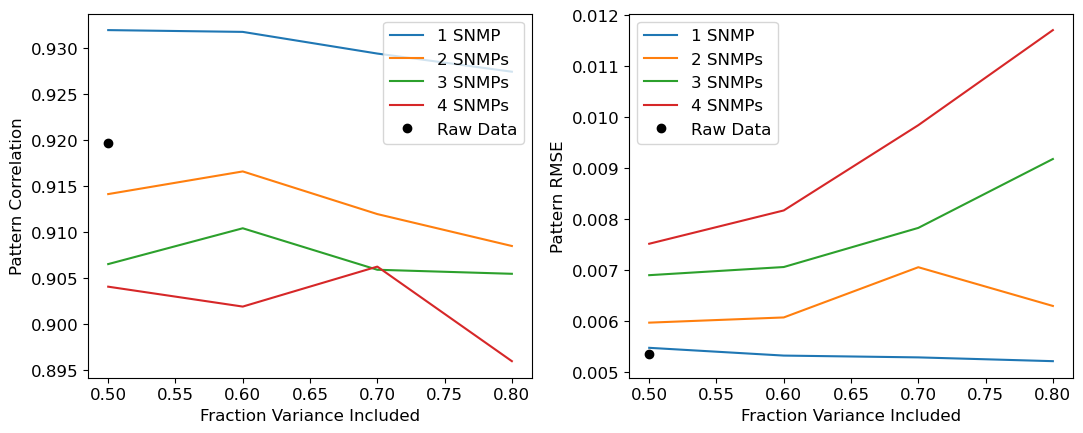

In [10]:
f=plt.figure(figsize=(11, 4.5))
plt.rcParams.update({'font.size': 12})
plt.subplot(1, 2, 1)
for il, N_SNMP in enumerate(N_SNMPs):
    plt.plot(truncations, np.mean(np.mean(corr_trend[:,:,:,il],axis=1),axis=0))
plt.plot(np.min(truncations),np.mean(np.mean(corr_trend_raw[:,:],axis=1),axis=0),"ok")
plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
if truncations[0]<1:
    plt.xlabel("Fraction Variance Included")
else:
    plt.xlabel("Truncation")
plt.ylabel("Pattern Correlation")
plt.subplot(1, 2, 2)
for il, N_SNMP in enumerate(N_SNMPs):
    plt.plot(truncations, np.sqrt(np.mean(np.mean(mse_trend[:,:,:,il],axis=1),axis=0)))
plt.plot(np.min(truncations),np.sqrt(np.mean(np.mean(mse_trend_raw[:,:],axis=1),axis=0)),"ok")
plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
if truncations[0]<1:
    plt.xlabel("Fraction Variance Included")
else:
    plt.xlabel("Truncation")
plt.ylabel("Pattern RMSE")
plt.tight_layout()
plt.savefig('/home/rjnglin/forcesmip/notebooks/figs/training/snmpof_trend_tas.pdf')

In [11]:
if 2+2==2 :
    for ig, model in enumerate(training_models):
        f=plt.figure(figsize=(11, 4.5))
        plt.rcParams.update({'font.size': 12})
        plt.subplot(1, 2, 1)
        for il, N_SNMP in enumerate(N_SNMPs):
            plt.plot(truncations, np.mean(corr_trend[ig,:,:,il],axis=0))
        plt.plot(np.min(truncations),np.mean(corr_trend_raw[ig,:],axis=0),"ok")
        plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
        if truncations[0]<1:
            plt.xlabel("Fraction Variance Included")
        else:
            plt.xlabel("Truncation")
        plt.ylabel("Pattern Correlation")
        plt.subplot(1, 2, 2)
        for il, N_SNMP in enumerate(N_SNMPs):
            plt.plot(truncations, np.sqrt(np.mean(mse_trend[ig,:,:,il],axis=0)))
        plt.plot(np.min(truncations),np.sqrt(np.mean(mse_trend_raw[ig,:],axis=0)),"ok")
        plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
        if truncations[0]<1:
            plt.xlabel("Fraction Variance Included")
        else:
            plt.xlabel("Truncation")
        plt.ylabel("Pattern RMSE")
        plt.tight_layout()

### Global-Mean Anomaly Correlation Coefficient (ACC) and RMSE

**(left; up = skillful)** Here we have computed the ACC with the ensemble mean at each grid point over the full time period (corresponding to the chosen Tier) then averagd in space. The ACC is then averaged over all training models and training members, then plotted against `truncations` for different values of `N_SNMPs`. 

**(right; down = skillful)** Here we have computed the MSE with respect to the ensemble mean over the full period (corresponding to the chosen Tier) then averaged in space. The MSE is averaged over all training models and training members, then square rooted, then plotted against `truncations` for different values of `N_SNMPs`. 

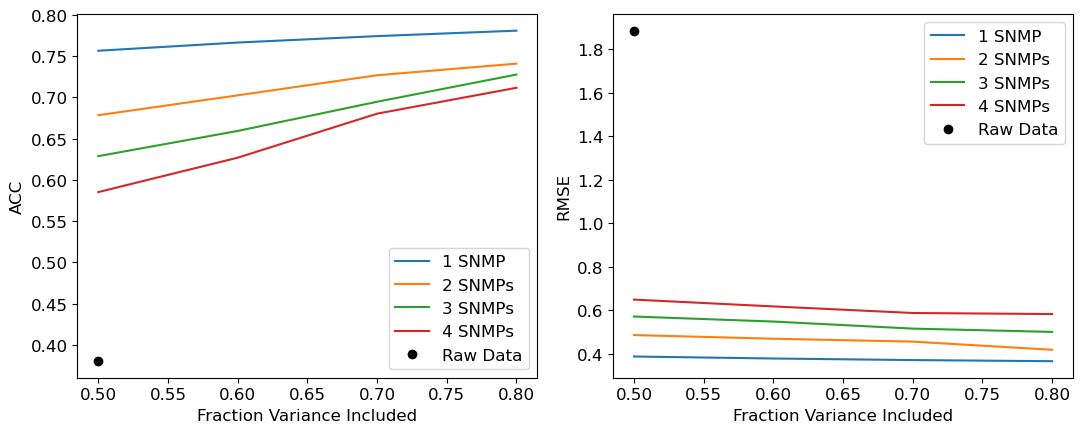

In [12]:
f=plt.figure(figsize=(11, 4.5))
plt.subplot(1, 2, 1)
for il, N_SNMP in enumerate(N_SNMPs):
    plt.plot(truncations, np.mean(np.mean(corr[:,:,:,il],axis=1),axis=0))
plt.plot(np.min(truncations),np.mean(np.mean(corr_raw[:,:],axis=1),axis=0),"ok")
plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
if truncations[0]<1:
    plt.xlabel("Fraction Variance Included")
else:
    plt.xlabel("Truncation")
plt.ylabel("ACC")
plt.subplot(1, 2, 2)
for il, N_SNMP in enumerate(N_SNMPs):
    plt.plot(truncations, np.sqrt(np.mean(np.mean(mse[:,:,:,il],axis=1),axis=0)))
plt.plot(np.min(truncations),np.mean(np.mean(mse_raw[:,:],axis=1),axis=0),"ok")
plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
if truncations[0]<1:
    plt.xlabel("Fraction Variance Included")
else:
    plt.xlabel("Truncation")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig('/home/rjnglin/forcesmip/notebooks/figs/training/snmp_spatiotemporal_tas.pdf')

In [13]:
if 2+2==2 :
    for ig, model in enumerate(training_models):
        f=plt.figure(figsize=(11, 4.5))
        plt.subplot(1, 2, 1)
        for il, N_SNMP in enumerate(N_SNMPs):
            plt.plot(truncations, np.mean(corr[ig,:,:,il],axis=0))
        plt.plot(np.min(truncations),np.mean(corr_raw[ig,:],axis=0),"ok")
        plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
        if truncations[0]<1:
            plt.xlabel("Fraction Variance Included")
        else:
            plt.xlabel("Truncation")
        plt.ylabel("ACC")
        plt.subplot(1, 2, 2)
        for il, N_SNMP in enumerate(N_SNMPs):
            plt.plot(truncations, np.sqrt(np.mean(mse[ig,:,:,il],axis=0)))
        plt.plot(np.min(truncations),np.mean(mse_raw[ig,:],axis=0),"ok")
        plt.legend(['1 SNMP','2 SNMPs','3 SNMPs','4 SNMPs','Raw Data'])
        if truncations[0]<1:
            plt.xlabel("Fraction Variance Included")
        else:
            plt.xlabel("Truncation")
        plt.ylabel("RMSE")
        plt.tight_layout()

## SNMP-OF of evaluation members

Now that we have undergone the time intensive task of training, we can choose values of `truncation` and `N_SNMPs` based on the above plots (there is no right way to do this), apply SNMP analysis to all training models and use the indentified fingerprints for optimal fingerprinting on the evalution members. Then we visualize the results. 

In [14]:
# manually set hyperparameters (based on training)
truncation = 0.7 # (truncation = 0.7 was chosen (semi-subjectively) based on training and used for submission)
N_SNMP = 1 # (N_SNMP = 1 was chosen (semi-subjectively) based on training and used for submission)

# initialize dictionaries for LFCA output
tks_eval_all = {}
patterns_eval_all = {}
X_forced_eval_all = {}
X_total_eval_all = {}

eval_models = evaluation_anomaly_maps.keys()
k = list(eval_models)

# extract coordinate vectors
lon_axis = evaluation_anomaly_maps[k[0]].lon
lat_axis = evaluation_anomaly_maps[k[0]].lat
time = evaluation_anomaly_maps[k[0]].time
# dimensions of the data matrix
n_timesteps = len(time)
nfeatures = nlat * nlon

# concatenate all training models
sst_anomalies = []
sst_anomalies_emean = []
include = [0, 1, 2, 3, 4]
for ia in include:
    temp = anomaly_maps_all[training_models[ia]]
    temp["time"] = anomaly_map_emean[training_models[0]].time
    sst_anomalies.append(temp)
    temp = anomaly_map_emean[training_models[ia]]
    temp["time"] = anomaly_map_emean[training_models[0]].time
    sst_anomalies_emean.append(temp)
sst_anomalies = xr.concat(sst_anomalies, dim="model")
sst_anomalies_emean = xr.concat(sst_anomalies_emean, dim="model")
#sst_anomalies = sst_anomalies.groupby('time.year').mean()  
#sst_anomalies_emean = sst_anomalies_emean.groupby('time.year').mean() 

# convert missing data mask from nans to zeros
mask = np.floor((np.nan_to_num(missing_data_mask_training[training_models[0]], nan=0) +
    np.nan_to_num(missing_data_mask_training[training_models[1]], nan=0) + 
    np.nan_to_num(missing_data_mask_training[training_models[2]], nan=0) +
    np.nan_to_num(missing_data_mask_training[training_models[3]], nan=0) + 
    np.nan_to_num(missing_data_mask_training[training_models[4]], nan=0))/5)

# run SNMP analysis on all 5 training models with chosen truncation 

# create cos(lat) weighting, with mask for missing data 
y, x = np.meshgrid(lat_axis,lon_axis)
area = np.cos(y*np.pi/180.) * np.transpose(mask)
area_weights = np.reshape(area,(nfeatures,1),order='F')

# combine lat & lon into a single spatial dimension
x = sst_anomalies.stack(sample=['model','mem','time']).stack(shape=['lat','lon'])
x_emean = sst_anomalies_emean.stack(sample=['model','time']).stack(shape=['lat','lon'])

# these give the spatial points (columns) where there are not and are missing data, in icol_ret and icol_disc, respectively
icol_ret = np.where(area_weights!=0)
icol_disc = np.where(area_weights==0)
# remove missing spatial points from x, x_emean, and area_weights
x = x[:,icol_ret[0]]
x_emean = x_emean[:,icol_ret[0]]
area_weights = np.transpose(area_weights[icol_ret[0],:])

print("SNMP Analysis of all Training Models")
# start timer
stime = clocktime.time()
# here is where SNMP is called
tks, snmps, fingerprints, snr, truncation =  snmpa(x, x_emean, truncation, area_weights)
etime = clocktime.time()
print()
print("Time elapsed: " + str(etime - stime) + " seconds")
print()

SNMP Analysis of all Training Models
Truncation = 35

Time elapsed: 408.9830377101898 seconds



In [15]:
for ie, eval_model in enumerate(eval_models):
    
    print("Model " + eval_model)
    
    tks_eval_all[eval_model] = {}
    patterns_eval_all[eval_model] = {}
    X_forced_eval_all[eval_model] = {}
    X_total_eval_all[eval_model] = {}
    
    # this is the data from each training model/member
    sst_anomalies = evaluation_anomaly_maps[eval_model]

    # extract coordinate vectors
    lon_axis = evaluation_anomaly_maps[eval_model].lon
    lat_axis = evaluation_anomaly_maps[eval_model].lat
    time = evaluation_anomaly_maps[eval_model].time
    # dimensions of the data matrix
    n_timesteps = len(time)
    nfeatures = nlat * nlon

    # create cos(lat) weighting, with mask for missing data 
    y, x = np.meshgrid(lat_axis,lon_axis)
    area = np.cos(y*np.pi/180.) * np.transpose(mask)
    area_weights = np.reshape(area,(nfeatures,1),order='F')

    # combine lat & lon into a single spatial dimension
    x_obs = sst_anomalies.stack(shape=['lat','lon']) 
    x_obs = x_obs - np.mean(x_obs,axis=0)
    scale = np.sqrt(area_weights/np.sum(area_weights))
    xs = x_obs*scale.T
    
    # these give the spatial points (columns) where there are not and are missing data, in icol_ret and icol_disc, respectively
    icol_ret = np.where(area_weights!=0)
    icol_disc = np.where(area_weights==0)
    # remove missing spatial points from x and area_weights
    x_obs= x_obs[:,icol_ret[0]]
    xs = xs[:,icol_ret[0]]
    xs = xs.values
    xs[np.isnan(xs)] = 0

    #optimal fingerprinting
    tk_evaluation = np.matmul(xs,fingerprints)
    for itk in range(tk_evaluation.shape[1]):
        tk_evaluation[:,itk] = tk_evaluation[:,itk]/np.std(tk_evaluation[:,itk])
    pattern_evaluation = np.matmul(tk_evaluation.T,x_obs.values)/(n_timesteps-1)
    # put back in missing data 
    nins = nfeatures - len(icol_ret[0]) #np.size(icol_disc[0])
    nrows = pattern_evaluation.shape[0]
    pattern_evaluation_aug = np.zeros((nrows,pattern_evaluation.shape[1]+nins))
    pattern_evaluation_aug[:] = np.nan
    pattern_evaluation_aug[:,icol_ret[0]] = pattern_evaluation

    # time axis
    time_plot = [t.year + t.month/12 for t in time.values]

    # forced response estimate from SNMP-OF
    X_forced = np.matmul(tk_evaluation[:,0:N_SNMP],pattern_evaluation_aug[0:N_SNMP,:])
    X_forced = X_forced.reshape(n_timesteps,nlat,nlon)
    X_forced = xr.DataArray(X_forced, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
    
    # put output in library
    tks_eval_all[eval_model] = tk_evaluation
    patterns_eval_all[eval_model] = pattern_evaluation_aug
    X_forced_eval_all[eval_model] = X_forced
    X_total_eval_all[eval_model] = sst_anomalies

Model 1A
Model 1B
Model 1C
Model 1D
Model 1E
Model 1F
Model 1G
Model 1H
Model 1I
Model 1J


## Plot the first four patterns and their timeseries for an evaluation member of choice

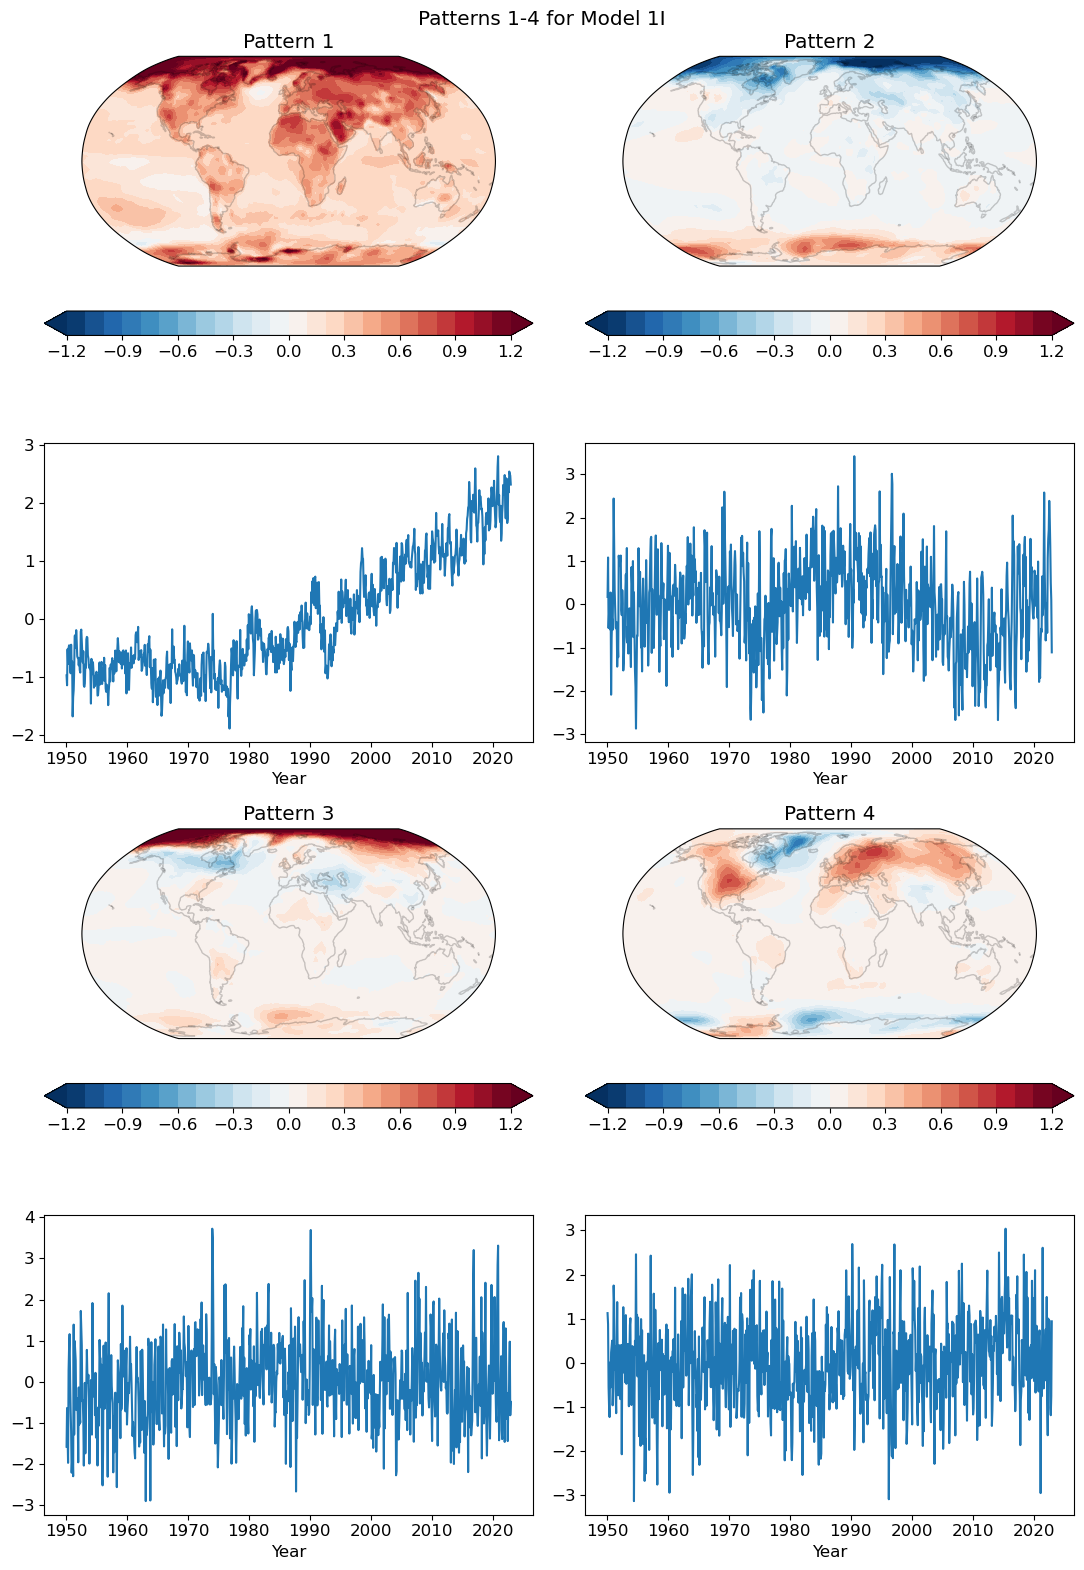

In [16]:
plot_model = '1I'

clev = np.arange(-1.2, 1.3, 0.1)
#clev = np.arange(-200, 205, 5)

tks_plot = tks_eval_all[plot_model]
patterns_plot = patterns_eval_all[plot_model]

LFCs_plot = (1,2,3,4) # currently just hard coded below

f=plt.figure(figsize=(11, 16))
for i in range(0,4):
    pattern = np.reshape(patterns_plot[i,...],(nlon,nlat),order='F')
    pattern[np.where(np.abs(pattern)>1.e5)] = np.nan
    if i>1:
        plt.subplot(4, 2, i+3, projection=ccrs.Robinson())
    else:
        plt.subplot(4, 2, i+1, projection=ccrs.Robinson())
    map_plot = np.transpose(pattern)
    cyclic_data, cyclic_longitude = add_cyclic_point(map_plot, coord=lon_axis)
    im = plt.contourf(cyclic_longitude, lat_axis, cyclic_data, clev, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    # colorbar
    plt.colorbar(orientation='horizontal')
    plt.title('Pattern '+str(i+1))
    if i>1:
        plt.subplot(4, 2, i+5)
    else:
        plt.subplot(4, 2, i+3)
    plt.plot(time_plot,tks_plot[:,i])
    plt.xlabel("Year")
    
plt.suptitle('Patterns 1-4 for Model '+plot_model)
plt.tight_layout()

## SNMP-OF estimate of forced trends over the full time period (based on chosen tier)

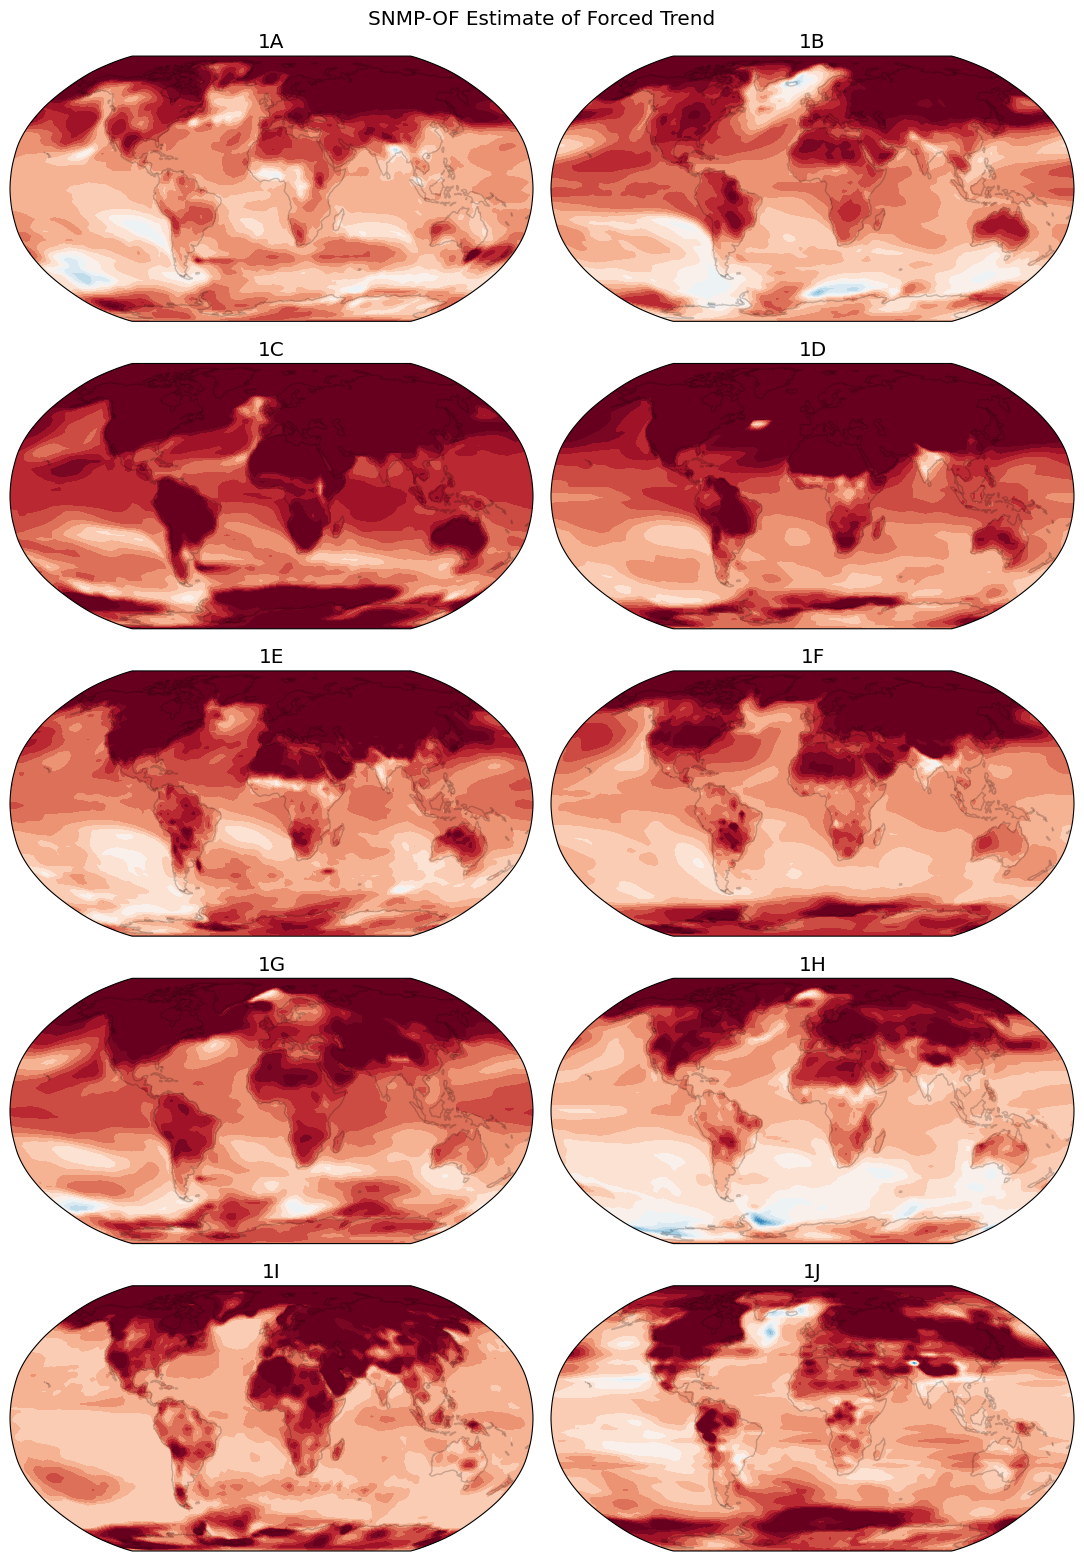

In [17]:
clevs = np.arange(-2, 2.2, 0.2)
#clevs = np.arange(-400, 405, 5)

f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1, projection=ccrs.Robinson())
    X_forced = X_forced_eval_all[eval_model]
    X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients
    map_plot = X_forced_trend.values*(time_plot[-1]-time_plot[0])
    cyclic_data, cyclic_longitude = add_cyclic_point(map_plot, coord=lon_axis)
    im = plt.contourf(cyclic_longitude, lat_axis, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(eval_model)
plt.suptitle('SNMP-OF Estimate of Forced Trend')
plt.tight_layout()

## Visualizing SNMP-OF forced response estimate for global mean

The real benefits of SNMP-OF aren't necessarily for the trend pattern over the full time period but in getting information about how this forced response pattern evolves in time (i.e., the full spatiotemporal complexity of the forced response). We visualize what SNMP-OF is doing to the raw data for the global mean and a few other specific timeseries

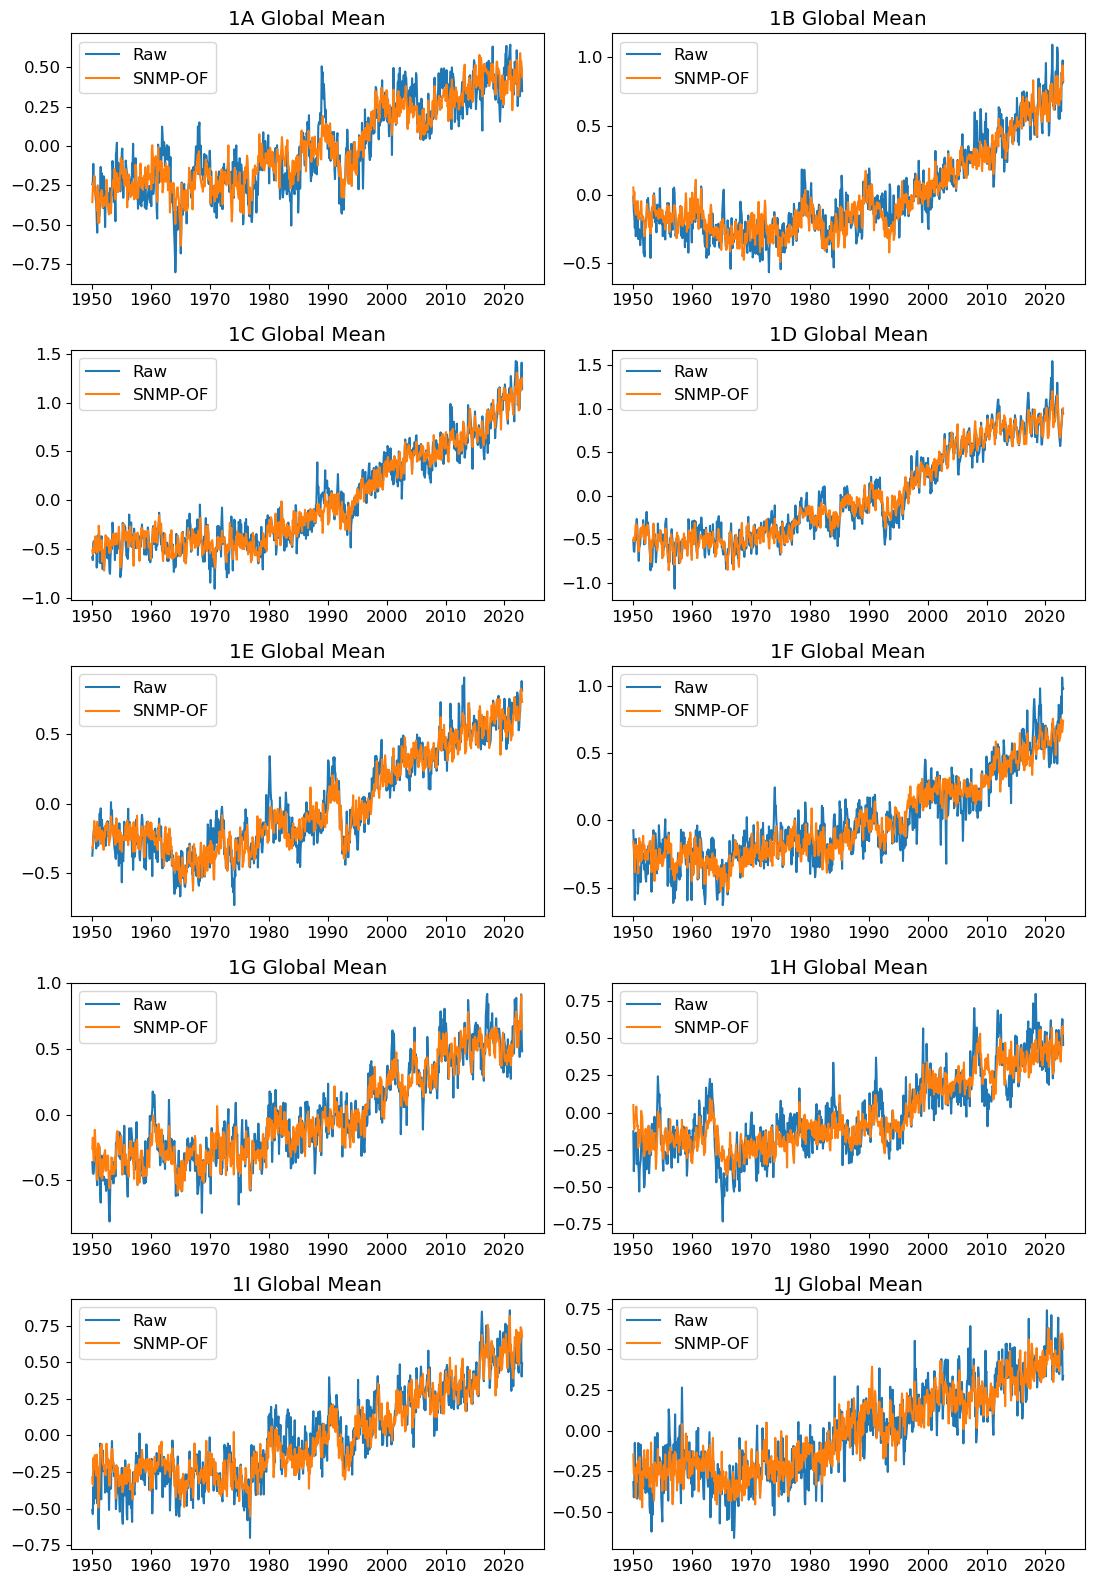

In [18]:
time_plot = [t.year + t.month/12 for t in time.values]
cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1)
    X_forced = X_forced_eval_all[eval_model]
    X_total = X_total_eval_all[eval_model]
    GMST_total = (X_total*cosw).mean('lon').mean('lat')
    GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
    plt.plot(time_plot,GMST_total)
    plt.plot(time_plot,GMST_forced)
    plt.title(eval_model+' Global Mean')
    plt.legend(['Raw','SNMP-OF'])
plt.tight_layout()

## And the same visualization for Niño3.4 region

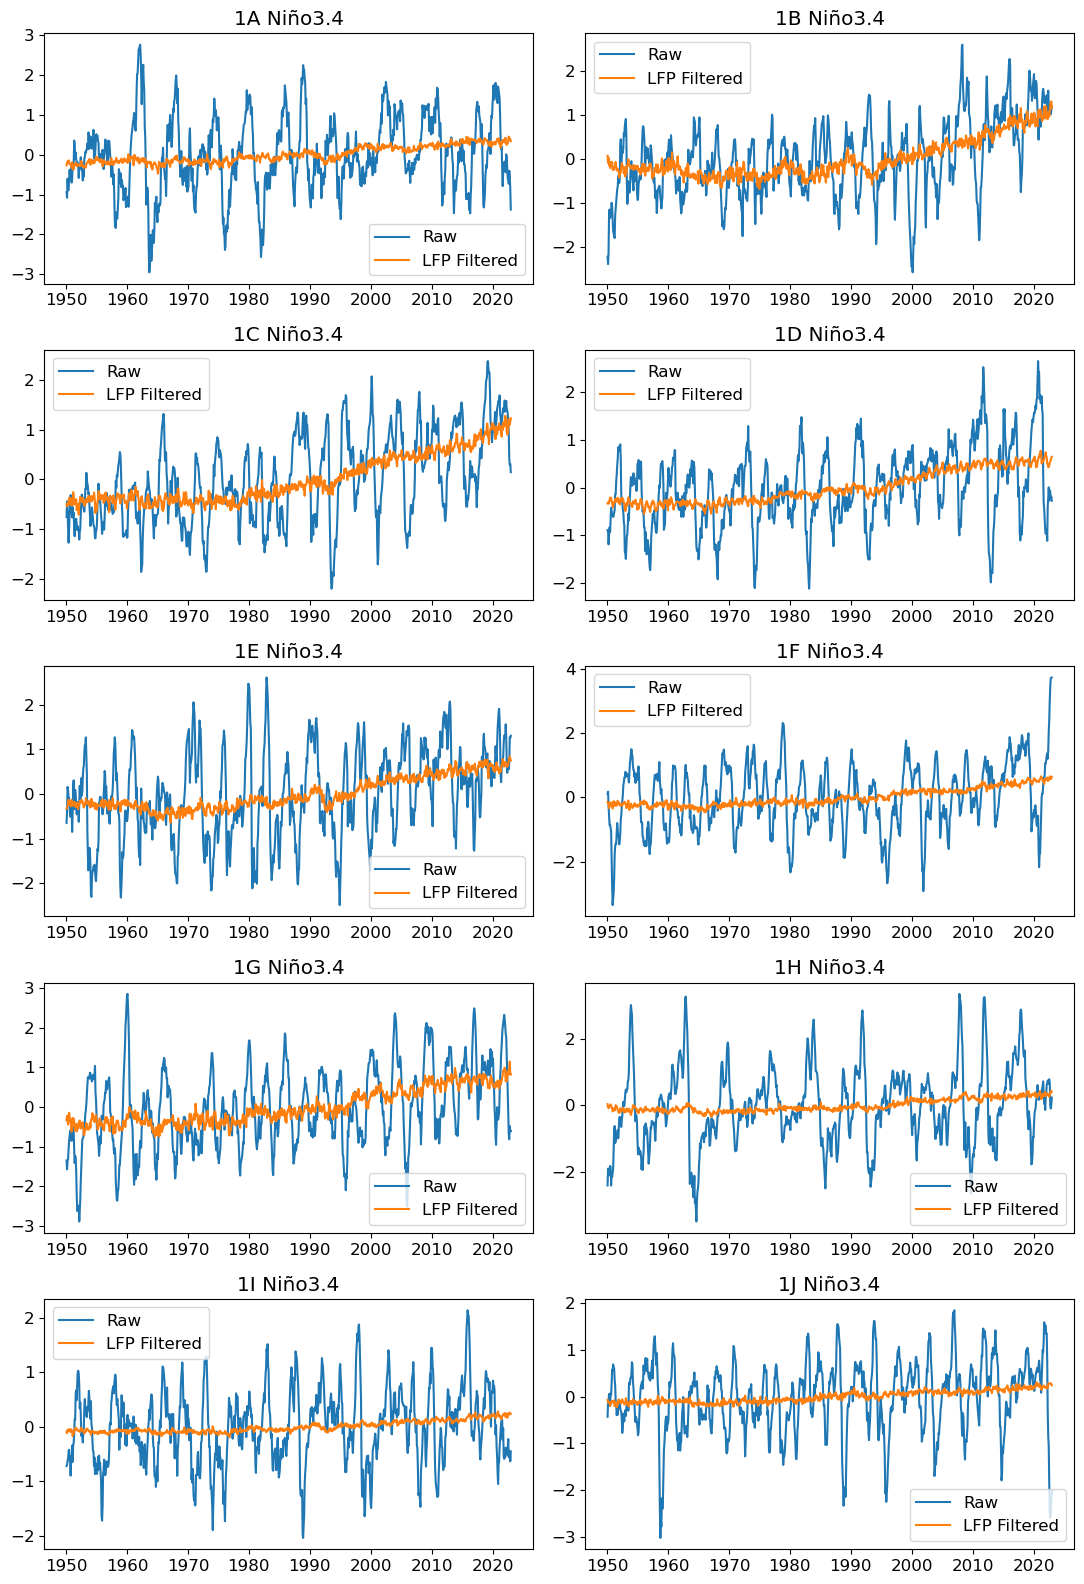

In [19]:
time_plot = [t.year + t.month/12 for t in time.values]
cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1)
    X_forced = X_forced_eval_all[eval_model]
    X_total = X_total_eval_all[eval_model]
    Nino34_forced = (X_forced*cosw).sel(lon=slice(190,240),lat=slice(-5,5)).mean('lon').mean('lat')
    Nino34_total = (X_total*cosw).sel(lon=slice(190,240),lat=slice(-5,5)).mean('lon').mean('lat')
    # if you want to compute the global mean and subtract that from Nino34:
    #GMST_total = (X_total*cosw).mean('lon').mean('lat')
    #GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
    plt.plot(time_plot,Nino34_total)
    plt.plot(time_plot,Nino34_forced)
    plt.title(eval_model+' Niño3.4')
    plt.legend(['Raw','LFP Filtered'])
plt.tight_layout()

## And the same visualization for the grid cell corresponding to Boulder or Zurich

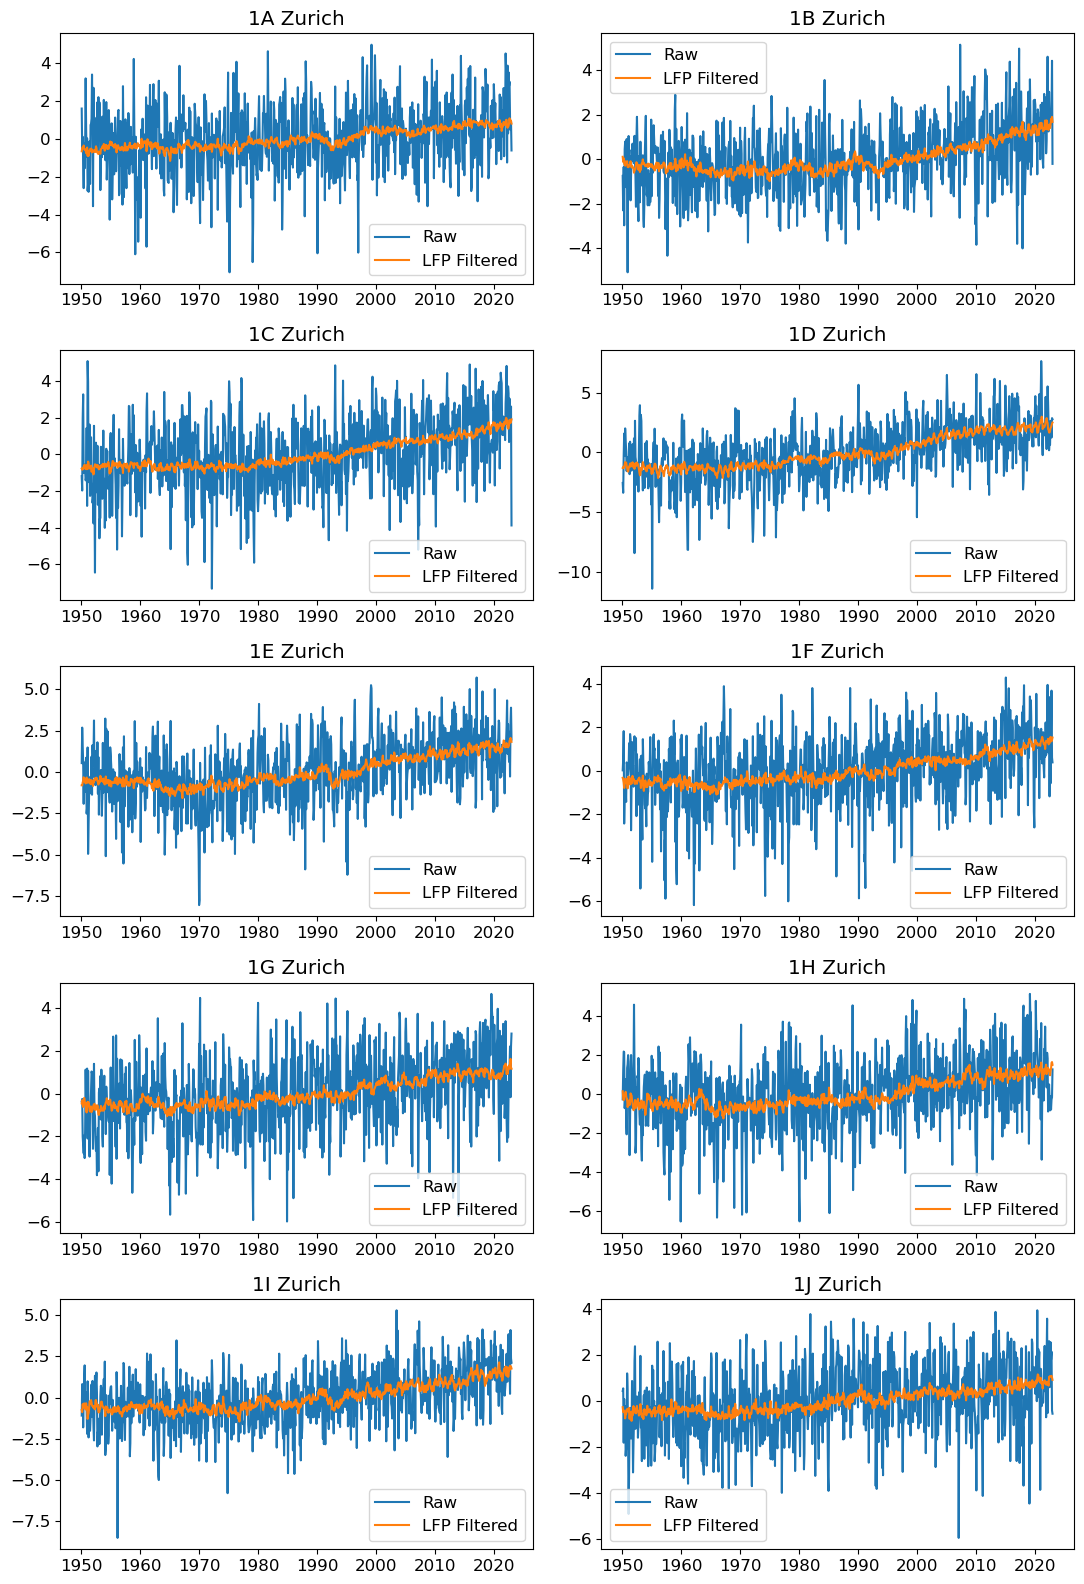

In [20]:
location = 'Zurich'

if ncvar == "tos":
    print('Skipping plot for ocean variable')
else:
    if location == 'Zurich':
        sel_lat = 47.4 # closest to 47.4°N
        sel_lon = 8.5 # closest to 8.5°E
    elif ftype == 'Boulder':
        sel_lat = 40.02 # closest to 40.02°N
        sel_lon = 254.7 #closest to 105.3°W
    else:
        raise ValueError('Only has options for Zurich and Boulder.')

    time_plot = [t.year + t.month/12 for t in time.values]
    cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
    f = plt.figure(figsize=(11, 16))
    for ie, eval_model in enumerate(eval_models):
        plt.subplot(5, 2, ie+1)
        X_forced = X_forced_eval_all[eval_model]
        X_total = X_total_eval_all[eval_model]
        Nino34_forced = (X_forced).sel(lon=8.75, lat=47.4, method='nearest')
        Nino34_total = (X_total).sel(lon=8.75, lat=47.4, method='nearest')
        # if you want to compute the global mean and subtract that from Nino34:
        #GMST_total = (X_total*cosw).mean('lon').mean('lat')
        #GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
        plt.plot(time_plot,Nino34_total)
        plt.plot(time_plot,Nino34_forced)
        plt.title(eval_model+' '+location)
        plt.legend(['Raw','LFP Filtered'])
    plt.tight_layout()

### Discussion Questions

* How would you choose between optimizing the skill metrics presented? Can you think of other skill metrics to use?
* We've evaluated the monthly variability and the full-period trend. How about timescales in between (e.g., annual means, 5-year means)? 
* Do you think this approach would work well for other variables of interest?

### NetCDF Output of Forced Response Estimate

In [21]:
name = "SNMP-OF.ETHClimDyn"

# ensure directory exists to write out data
if not os.path.exists('data/'):
    os.mkdir(outdir)

for ie, eval_model in enumerate(eval_models):
    filename = outdir+ncvar+"."+eval_model+"."+name+".nc"
    X_forced = X_forced_eval_all[eval_model]
    X_forced = X_forced.rename("forced_component")
    print ('saving to ', filename)
    X_forced.to_netcdf(path=filename)
    X_forced.close()
    print ('finished saving')

saving to  data/tas.1A.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1B.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1C.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1D.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1E.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1F.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1G.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1H.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1I.SNMP-OF.ETHClimDyn.nc
finished saving
saving to  data/tas.1J.SNMP-OF.ETHClimDyn.nc
finished saving


In [18]:
# This was used to save trend estimates for the ForceSMIP Hackathon Bakeoff
eval_model = "1H"
name = "SNMP-OF.ETHClimDyn"

# ensure directory exists to write out data
if not os.path.exists('data/'):
    os.mkdir(outdir)
    
filename = outdir+eval_model+"."+ncvar+"."+name+".nc"

X_forced = X_forced_eval_all[eval_model]
X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients*np.ceil(time_plot[-1]-time_plot[0])
X_forced_trend = X_forced_trend.rename("forced_component")

print ('saving to ', filename)
X_forced_trend.to_netcdf(path=filename)
X_forced_trend.close()
print ('finished saving')

saving to  data/1H.tas.LFCA.Wills.nc
finished saving
